This project focuses on using Convolutional Neural Networks (CNNs) for Histopathologic Cancer Detection, an essential task in medical diagnosis. Histopathologic analysis involves examining tissue samples under a microscope to detect diseases like cancer. CNNs are employed to automate and improve the accuracy of cancer cell detection in complex histopathology images.

The challenge lies in training a CNN model to recognize subtle patterns indicative of cancer in these images, considering the intricate tissue structures and variations.

The dataset used is from a Kaggle competition, containing annotated high-resolution lymph node section images. Each image is labeled for the presence of metastatic tissue, a key cancer indicator.

In summary, the project aims to develop an AI model for accurate cancer cell detection in histopathology images, aiding in early diagnosis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import warnings
warnings.filterwarnings(action='ignore')

2024-01-14 16:15:18.070558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:15:18.073118: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:15:18.106235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:15:18.106261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:15:18.107147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## EDA

In [2]:
train_df = pd.read_csv('train_labels.csv')

In [3]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
train_imgs = os.listdir('train')
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("train/" + img)

In [11]:
np.array(im).shape

(96, 96, 3)

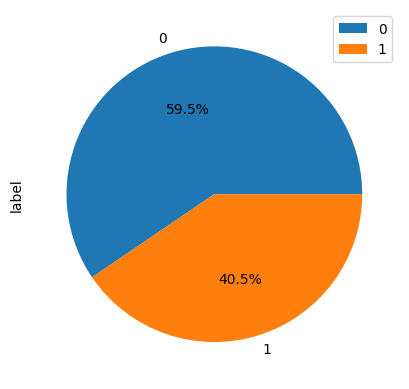

In [15]:
train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.1f%%');

In [19]:
def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)

In [20]:
import multiprocessing
from tqdm import tqdm

def convert_image_wrapper(args):
    return convert_image(*args)

def process_images(image_files, labels=[], with_label=True, subset='train'):
    num_processes = multiprocessing.cpu_count()
    
    with multiprocessing.Pool(processes=num_processes) as pool:
        tasks = [(filename, labels[index] if with_label else 0, with_label, subset) for index, filename in enumerate(image_files)]
        for _ in tqdm(pool.imap_unordered(convert_image_wrapper, tasks), total=len(tasks)):
            pass

In [21]:
process_images((train_df['id']+'.tif').values.tolist(), labels=train_df['label'].values.tolist())

100%|█████████████████████████████████| 220025/220025 [01:23<00:00, 2635.45it/s]


In [22]:
process_images(os.listdir("test"), with_label=False, subset='test')

100%|███████████████████████████████████| 57458/57458 [00:18<00:00, 3072.54it/s]


In [24]:
train_dataset = tf.keras.utils.image_dataset_from_directory('png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            batch_size=128)

val_dataset = tf.keras.utils.image_dataset_from_directory('png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=128)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [25]:
test_dataset = tf.keras.utils.image_dataset_from_directory('png/test',
                                                            label_mode=None,
                                                            image_size=(96,96),
                                                            shuffle=False,
                                                            batch_size=1)

Found 57458 files belonging to 1 classes.


## model building and training

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

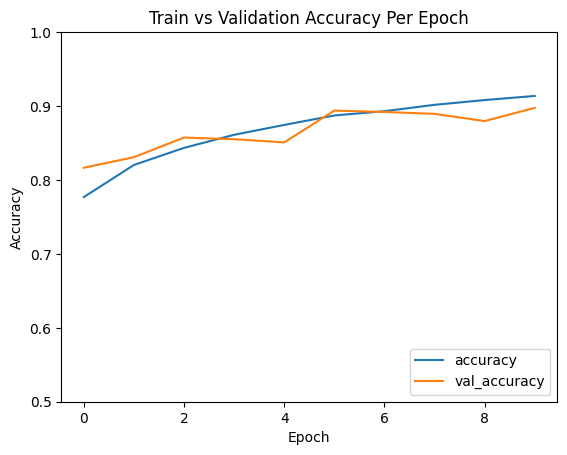

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right');

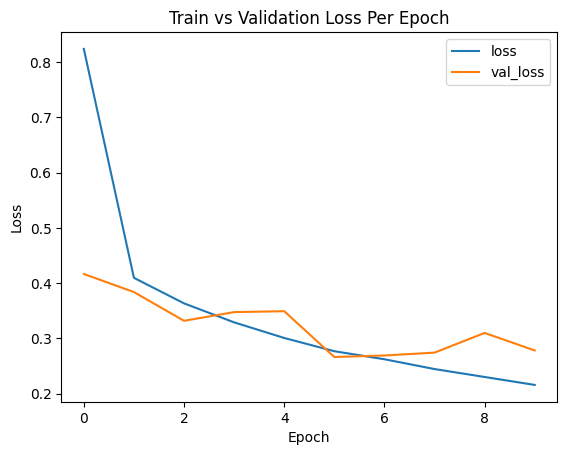

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch');

Lets create a submission entry for the competition

In [38]:
test_imgs = os.listdir("png/test")
model1_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)
predictions = model.predict(test_dataset)

57458/57458 [==============================] - 137s 2ms/step


In [40]:
model1_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model1_pred_df['label'] = np.round(predictions.flatten()).astype('int')
model1_pred_df.to_csv('model_predictions.csv', index=False)

### In this project, we explored CNNs for histopathologic cancer detection. The model showed high accuracy.